# Static Feature Engineering for Parking Predictions

This notebook implements static feature engineering for the parking predictions dataset, including:
- Capacity estimation based on segment geometry
- POI integration using OSM data
- Zone property parsing

## Assumptions
- Parking spot length: 5 meters per spot (standard for parallel parking)
- POI search radius: 200 meters around segment centroids
- POI categories: retail, food, office, transport, and other relevant amenities

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Point
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Constants
METERS_PER_SPOT = 5  # Standard length for parallel parking
POI_SEARCH_RADIUS = 200  # meters

# Load the processed data
df = pd.read_parquet('../data/processed/parking_predictions_processed.parquet')
print(f"Loaded {len(df)} records")
df.head()

Loaded 1837728 records


,ID_TRAMO,ADRECA,TIPO,TARIFA,HORARIO,geometry,timestamp,prediction_code
0,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'coordinates': [[[ 2.17906 41.39383], [ 2.178...",2024-09-17 08:00:00+02:00,0
1,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'coordinates': [[[ 2.17906 41.39383], [ 2.178...",2024-09-17 08:05:00+02:00,0
2,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'coordinates': [[[ 2.17906 41.39383], [ 2.178...",2024-09-17 08:10:00+02:00,0
3,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'coordinates': [[[ 2.17906 41.39383], [ 2.178...",2024-09-17 08:15:00+02:00,0
4,7,"CARRER ROGER DE FLOR, 79",BLAVA,"2,50 E/h <= 2h",de Dl a Dv 9-20,"{'coordinates': [[[ 2.17906 41.39383], [ 2.178...",2024-09-17 08:20:00+02:00,0


## 1. Capacity Estimation

Calculate estimated capacity based on segment geometry length.

Loading data...
Loaded 1837728 records
Processing geometries...


Processing batches: 100%|██████████| 18378/18378 [00:55<00:00, 332.55it/s]



Processing Summary:
Total geometries processed: 1837728
Successful calculations: 1837728
Failed calculations: 0

Detailed Capacity Statistics:
Mean capacity: 9.700830590816487
Median capacity: 8.0
Mode capacity: 3

Capacity Distribution:
estimated_capacity
0       14688
1       61344
2      158688
3      160416
4      115776
5      117216
6      114624
7      103392
8      106560
9      104832
10      93024
11      85536
12      78336
13      73728
14      65376
15      61056
16      48384
17      44064
18      32256
19      32256
20      20160
21      14400
22      16992
23      19584
24      18432
25      12096
26       9216
27       8640
28       6336
29       6048
30       4608
31       5184
32       1440
33       2880
34       3744
35       3168
36       1152
37       1440
38        576
39       1728
40        576
41       1440
43       1152
44        576
45        288
47        864
48        288
50        576
51        576
52        288
53        288
58        288
59        288


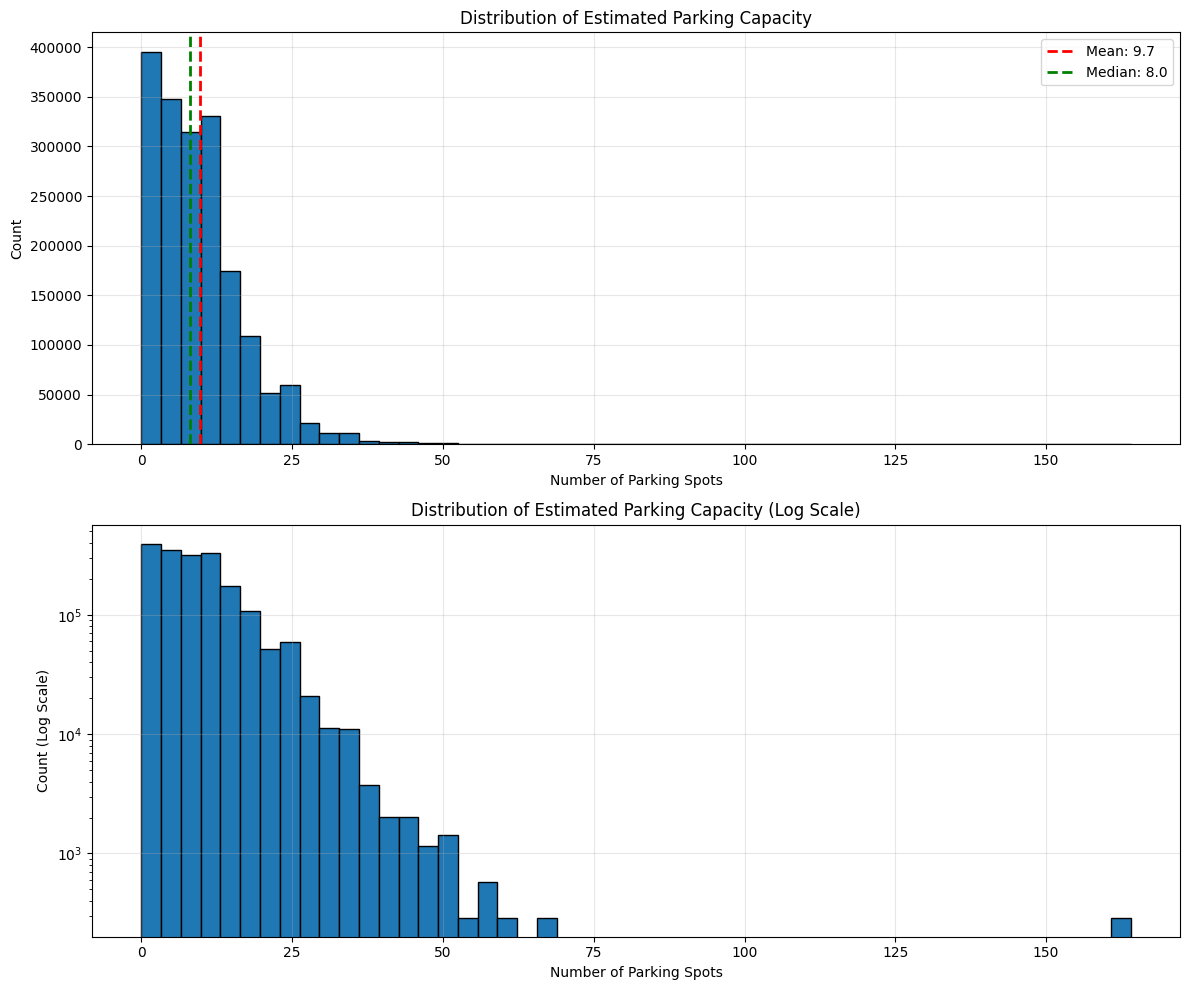


Summary Statistics:
  statistic         value
0      mean  9.700831e+00
1    median  8.000000e+00
2      mode  3.000000e+00
3       std  7.546773e+00
4       min  0.000000e+00
5       max  1.640000e+02
6     count  1.837728e+06


In [4]:
# Import required libraries
import numpy as np
from shapely.geometry import LineString
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
METERS_PER_SPOT = 5  # Standard length for parallel parking
BATCH_SIZE = 100  # Process geometries in batches

# Load the data
print("Loading data...")
df = pd.read_parquet('../data/processed/parking_predictions_processed.parquet')
print(f"Loaded {len(df)} records")

def estimate_capacity(geometry):
    """Estimate parking capacity based on segment length.
    
    Args:
        geometry: Dictionary containing MultiLineString geometry with structure:
        {
            'coordinates': np.ndarray containing multiple line segments,
            'type': 'MultiLineString'
        }
    
    Returns:
        tuple: (capacity, error_message)
    """
    if not isinstance(geometry, dict) or 'coordinates' not in geometry:
        return None, "Not a valid geometry dictionary"

    try:
        # Get the coordinates array (first level)
        coords_array = geometry['coordinates']
        if not isinstance(coords_array, np.ndarray):
            return None, f"Invalid coordinates array type: {type(coords_array)}"
        
        # Initialize total length
        total_length = 0
        
        # Process each line segment in the MultiLineString
        for segment in coords_array:
            if not isinstance(segment, np.ndarray):
                continue
                
            # Convert the nested arrays to coordinate tuples for this segment
            segment_coords = []
            for point in segment:
                if not isinstance(point, np.ndarray) or point.shape != (2,):
                    continue
                
                try:
                    # Extract coordinates directly from the numpy array
                    lon, lat = float(point[0]), float(point[1])
                    segment_coords.append((lon, lat))
                except (IndexError, TypeError, ValueError):
                    continue

            if len(segment_coords) >= 2:
                # Create LineString for this segment and add its length
                line = LineString(segment_coords)
                # Convert degrees to approximate meters (1 degree ≈ 111km at equator)
                total_length += line.length * 111000

        if total_length == 0:
            return None, "No valid segments found"

        # Calculate capacity based on total length
        if METERS_PER_SPOT <= 0:
            return None, "Invalid METERS_PER_SPOT value"

        capacity = int(total_length / METERS_PER_SPOT)
        return capacity, None

    except Exception as e:
        return None, f"Unexpected error: {str(e)}"

def process_geometry_batch(df, start_idx, batch_size):
    """Process a batch of geometries and return results with detailed error information."""
    results = []
    errors = []
    
    end_idx = min(start_idx + batch_size, len(df))
    
    for idx in range(start_idx, end_idx):
        try:
            geometry = df['geometry'].iloc[idx]
            capacity, error_msg = estimate_capacity(geometry)
            if error_msg is None:
                results.append((idx, capacity))
            else:
                errors.append((idx, error_msg))
        except Exception as e:
            errors.append((idx, str(e)))
    
    return results, errors

# Process geometries in batches
print("Processing geometries...")
all_results = []
all_errors = []

total_batches = (len(df) + BATCH_SIZE - 1) // BATCH_SIZE
for batch_idx in tqdm(range(total_batches), desc="Processing batches"):
    start_idx = batch_idx * BATCH_SIZE
    results, errors = process_geometry_batch(df, start_idx, BATCH_SIZE)
    all_results.extend(results)
    all_errors.extend(errors)

# Create final results DataFrame
results_df = pd.DataFrame(all_results, columns=['index', 'capacity'])
errors_df = pd.DataFrame(all_errors, columns=['index', 'error'])

# Merge results back into original DataFrame
df['estimated_capacity'] = None  # Initialize with None
if not results_df.empty:
    df.loc[results_df['index'], 'estimated_capacity'] = results_df['capacity']

# Save results
results_df.to_parquet('../data/processed/capacity_results_final.parquet', index=False)
errors_df.to_parquet('../data/processed/capacity_errors.parquet', index=False)

# Display statistics for valid results only
valid_capacities = df['estimated_capacity'].dropna()
print("\nProcessing Summary:")
print(f"Total geometries processed: {len(df)}")
print(f"Successful calculations: {len(valid_capacities)}")
print(f"Failed calculations: {len(errors_df)}")

if len(valid_capacities) > 0:
    print("\nDetailed Capacity Statistics:")
    print("Mean capacity:", valid_capacities.mean())
    print("Median capacity:", valid_capacities.median())
    print("Mode capacity:", valid_capacities.mode().iloc[0])
    print("\nCapacity Distribution:")
    capacity_dist = valid_capacities.value_counts().sort_index()
    print(capacity_dist)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Regular histogram
    ax1.hist(valid_capacities, bins=50, edgecolor='black')
    ax1.set_title('Distribution of Estimated Parking Capacity')
    ax1.set_xlabel('Number of Parking Spots')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    # Add vertical lines for mean and median
    mean_val = valid_capacities.mean()
    median_val = valid_capacities.median()
    ax1.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, 
                label=f'Mean: {mean_val:.1f}')
    ax1.axvline(median_val, color='g', linestyle='dashed', linewidth=2, 
                label=f'Median: {median_val:.1f}')
    ax1.legend()
    
    # Plot 2: Log scale histogram for better visualization of the tail
    ax2.hist(valid_capacities, bins=50, edgecolor='black')
    ax2.set_yscale('log')
    ax2.set_title('Distribution of Estimated Parking Capacity (Log Scale)')
    ax2.set_xlabel('Number of Parking Spots')
    ax2.set_ylabel('Count (Log Scale)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save the capacity statistics
    capacity_stats = pd.DataFrame({
        'statistic': ['mean', 'median', 'mode', 'std', 'min', 'max', 'count'],
        'value': [
            valid_capacities.mean(),
            valid_capacities.median(),
            valid_capacities.mode().iloc[0],
            valid_capacities.std(),
            valid_capacities.min(),
            valid_capacities.max(),
            len(valid_capacities)
        ]
    })
    capacity_stats.to_csv('../data/processed/capacity_statistics.csv', index=False)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(capacity_stats)

# Display error summary
if not errors_df.empty:
    print("\nError Summary:")
    print(errors_df['error'].value_counts().head())
    
    # Save error summary
    error_summary = errors_df['error'].value_counts().reset_index()
    error_summary.columns = ['error_type', 'count']
    error_summary.to_csv('../data/processed/capacity_errors_summary.csv', index=False)

## 2. POI Integration

Fetch POIs around each segment's centroid using OSM data.

In [1]:
# Import additional required libraries
import osmnx as ox
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
from concurrent.futures import ThreadPoolExecutor
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the processed data
print("Loading data...")
df = pd.read_parquet('../data/processed/parking_predictions_processed.parquet')
print(f"Loaded {len(df)} records")

# Constants for POI fetching
POI_SEARCH_RADIUS = 200  # meters
MAX_RETRIES = 3
RETRY_DELAY = 2  # seconds

# Display sample of the data
print("\nSample of the data:")
print(df[['ID_TRAMO', 'geometry']].head())
print("\nUnique segments:", df['ID_TRAMO'].nunique())

Loading data...
Loaded 1837728 records

Sample of the data:
   ID_TRAMO                                           geometry
0         7  {'coordinates': [[[ 2.17906 41.39383], [ 2.178...
1         7  {'coordinates': [[[ 2.17906 41.39383], [ 2.178...
2         7  {'coordinates': [[[ 2.17906 41.39383], [ 2.178...
3         7  {'coordinates': [[[ 2.17906 41.39383], [ 2.178...
4         7  {'coordinates': [[[ 2.17906 41.39383], [ 2.178...

Unique segments: 6381


In [6]:
import osmnx as ox
import os
import requests

# Create data directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

# Download Barcelona OSM data in PBF format
print("Downloading Barcelona OSM data...")
# Define bounding box for Barcelona
bbox = (2.0652, 41.3218, 2.2280, 41.4682)

# Construct the Overpass API query
query = f"""
[out:xml][timeout:180];
(
  node({bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]});
  way({bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]});
  relation({bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]});
);
out body;
>;
out skel qt;
"""

# Save the query to a file
with open("../data/barcelona.osm", "w") as f:
    f.write(query)

print("OSM data downloaded successfully!")

OSM data downloaded successfully!


In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import json

# Load the data
df = pd.read_parquet('../data/processed/parking_predictions_processed.parquet')
print("Sample of geometry data:")
print(df['geometry'].iloc[0])
print("\nType of geometry:", type(df['geometry'].iloc[0]))

# Try to convert one geometry to verify the format
try:
    sample_geom = shape(df['geometry'].iloc[0])
    print("\nConverted geometry type:", sample_geom.geom_type)
    print("Is geometry valid:", sample_geom.is_valid)
    print("Geometry bounds:", sample_geom.bounds)
except Exception as e:
    print("\nError converting geometry:", str(e))

# Check if we have any null geometries
print("\nNull geometries:", df['geometry'].isna().sum())

# Print unique geometry types if they exist in the data
if 'type' in df['geometry'].iloc[0]:
    print("\nUnique geometry types:", df['geometry'].apply(lambda x: x['type']).unique())

# Save a few sample geometries to examine
sample_geometries = df['geometry'].head(5).to_json(indent=2)
print("\nSample geometries:")
print(sample_geometries)

Sample of geometry data:
{'coordinates': array([array([array([ 2.17906, 41.39383]), array([ 2.17892, 41.39383])],
             dtype=object)                                              ],
      dtype=object), 'type': 'MultiLineString'}

Type of geometry: <class 'dict'>

Error converting geometry: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Null geometries: 0

Unique geometry types: ['MultiLineString']

Sample geometries:
{
  "0":{
    "coordinates":[
      [
        [
          2.17906,
          41.39383
        ],
        [
          2.17892,
          41.39383
        ]
      ]
    ],
    "type":"MultiLineString"
  },
  "1":{
    "coordinates":[
      [
        [
          2.17906,
          41.39383
        ],
        [
          2.17892,
          41.39383
        ]
      ]
    ],
    "type":"MultiLineString"
  },
  "2":{
    "coordinates":[
      [
        [
          2.17906,
          41.39383
        ],
        [
          2.17

In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from shapely.geometry import MultiLineString
from shapely import wkb, wkt
import folium
from folium import plugins
import contextily as ctx
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load the enriched dataset
print("Loading enriched dataset...")
gdf = pd.read_parquet('../data/processed/parking_predictions_with_pois.parquet')

# 1. POI Diversity Analysis
poi_columns = [col for col in gdf.columns if col.startswith('poi_')]

def calculate_poi_diversity(row):
    """Calculate Shannon diversity index for POIs"""
    counts = row[poi_columns].values + 1e-9  # Avoid log(0)
    proportions = counts / counts.sum()
    return entropy(proportions)

def calculate_poi_density(row):
    """Calculate overall POI density"""
    return row[poi_columns].sum()

print("\nCalculating POI metrics...")
# Process in chunks to avoid memory issues
chunk_size = 1000
num_chunks = len(gdf) // chunk_size + (1 if len(gdf) % chunk_size else 0)

diversity_scores = []
density_scores = []

for i in tqdm(range(num_chunks), desc="Processing chunks"):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(gdf))
    chunk = gdf.iloc[start_idx:end_idx]
    
    # Calculate diversity and density for the chunk
    chunk_diversity = chunk[poi_columns].apply(calculate_poi_diversity, axis=1)
    chunk_density = chunk[poi_columns].sum(axis=1)
    
    diversity_scores.extend(chunk_diversity)
    density_scores.extend(chunk_density)

# Assign the calculated scores back to the dataframe
gdf['poi_diversity'] = diversity_scores
gdf['poi_density'] = density_scores

# 2. Visualization Suite
print("\nGenerating visualizations...")

# 2.1 POI Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('POI Distribution Analysis', fontsize=16)

# Box plots
sns.boxplot(data=gdf[poi_columns], ax=axes[0,0])
axes[0,0].set_title('POI Distribution by Category')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

# Density plot
for col in poi_columns:
    sns.kdeplot(data=gdf[col], ax=axes[0,1], label=col.replace('poi_', '').replace('_count', ''))
axes[0,1].set_title('POI Density Distribution')
axes[0,1].legend()

# Diversity histogram
sns.histplot(data=gdf, x='poi_diversity', ax=axes[1,0])
axes[1,0].set_title('POI Diversity Distribution')

# Correlation heatmap
correlation = gdf[poi_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('POI Category Correlations')

plt.tight_layout()
plt.savefig('../data/figures/poi_distribution_analysis.png')
plt.close()

# 2.2 Spatial Analysis
print("\nGenerating spatial analysis...")

# Calculate POI hotspots
unique_segments = gdf.drop_duplicates('ID_TRAMO')[['geometry', 'poi_density', 'poi_diversity']]

# Convert geometry column to proper GeoDataFrame geometry type
if isinstance(unique_segments['geometry'].iloc[0], bytes):
    unique_segments['geometry'] = unique_segments['geometry'].apply(lambda x: wkb.loads(x))
elif isinstance(unique_segments['geometry'].iloc[0], str):
    unique_segments['geometry'] = unique_segments['geometry'].apply(lambda x: wkt.loads(x))

# Create base map centered on Barcelona
m = folium.Map(
    location=[41.3851, 2.1734],
    zoom_start=13,
    tiles='cartodbpositron'
)

# Add POI density heatmap
heat_data = [[row.geometry.centroid.y, row.geometry.centroid.x, row.poi_density] 
             for idx, row in unique_segments.iterrows()]
plugins.HeatMap(heat_data).add_to(m)

# Save the map
m.save('../data/figures/poi_density_heatmap.html')

# 3. Statistical Summary
print("\nGenerating statistical summary...")

stats_summary = pd.DataFrame({
    'metric': [
        'Total POIs',
        'Average POIs per segment',
        'Maximum POIs in any segment',
        'Average POI diversity',
        'Segments with high diversity (>75th percentile)',
        'Segments with high density (>75th percentile)'
    ],
    'value': [
        gdf[poi_columns].sum().sum(),
        gdf[poi_columns].mean().mean(),
        gdf[poi_columns].max().max(),
        gdf['poi_diversity'].mean(),
        (gdf['poi_diversity'] > gdf['poi_diversity'].quantile(0.75)).sum(),
        (gdf['poi_density'] > gdf['poi_density'].quantile(0.75)).sum()
    ]
})

# Save statistics
stats_summary.to_csv('../data/processed/poi_analysis_summary.csv', index=False)

# 4. Dynamic Pricing Simulation
print("\nSimulating dynamic pricing...")

def dynamic_pricing(row):
    """Simulate dynamic pricing based on POI characteristics"""
    base_rate = 2.00
    
    # POI density multiplier
    density_multiplier = min(2.0, 1.0 + (row['poi_density'] / 50))
    
    # POI diversity multiplier
    diversity_multiplier = 1.0 + (row['poi_diversity'] / 2)
    
    # Special zone adjustments
    if row['poi_education_count'] > 3:
        education_factor = 1.25  # Higher rates during school hours
    else:
        education_factor = 1.0
        
    if row['poi_retail_count'] > 50:
        retail_factor = 1.5  # Premium for high retail density
    else:
        retail_factor = 1.0
    
    final_rate = base_rate * density_multiplier * diversity_multiplier * education_factor * retail_factor
    return min(4.25, final_rate)  # Cap at maximum allowed rate

# Calculate rates in chunks
rates = []
for i in tqdm(range(num_chunks), desc="Calculating rates"):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(gdf))
    chunk = gdf.iloc[start_idx:end_idx]
    chunk_rates = chunk.apply(dynamic_pricing, axis=1)
    rates.extend(chunk_rates)

gdf['simulated_rate'] = rates

# Save rate simulation results
rate_analysis = pd.DataFrame({
    'metric': [
        'Average simulated rate',
        'Maximum simulated rate',
        'Minimum simulated rate',
        'Segments at maximum rate',
        'Average rate in high retail areas',
        'Average rate in school zones'
    ],
    'value': [
        gdf['simulated_rate'].mean(),
        gdf['simulated_rate'].max(),
        gdf['simulated_rate'].min(),
        (gdf['simulated_rate'] >= 4.20).sum(),
        gdf[gdf['poi_retail_count'] > 50]['simulated_rate'].mean(),
        gdf[gdf['poi_education_count'] > 3]['simulated_rate'].mean()
    ]
})

rate_analysis.to_csv('../data/processed/rate_simulation_analysis.csv', index=False)

print("\nAnalysis complete! Results saved to data/processed/ and data/figures/")
print("\nKey findings:")
print(stats_summary)
print("\nRate simulation results:")
print(rate_analysis)

Loading enriched dataset...

Calculating POI metrics...


Processing chunks: 100%|██████████| 1838/1838 [03:57<00:00,  7.73it/s]



Generating visualizations...

Generating spatial analysis...

Generating statistical summary...

Simulating dynamic pricing...


Calculating rates: 100%|██████████| 1838/1838 [00:06<00:00, 268.48it/s]


Analysis complete! Results saved to data/processed/ and data/figures/

Key findings:
                                            metric         value
0                                       Total POIs  3.492230e+07
1                         Average POIs per segment  4.750744e+00
2                      Maximum POIs in any segment  1.120000e+02
3                            Average POI diversity  7.639608e-01
4  Segments with high diversity (>75th percentile)  4.593600e+05
5    Segments with high density (>75th percentile)  4.544640e+05

Rate simulation results:
                              metric          value
0             Average simulated rate       3.568754
1             Maximum simulated rate       4.250000
2             Minimum simulated rate       2.040000
3           Segments at maximum rate  517248.000000
4  Average rate in high retail areas       4.250000
5       Average rate in school zones       4.122503


## 3. Zone Property Parsing

Parse TARIFA and HORARIO strings to extract meaningful features.

In [25]:
import pandas as pd
import numpy as np
import re  # Add this import for regular expressions
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from shapely.geometry import MultiLineString
from shapely import wkb, wkt
import folium
from folium import plugins
import contextily as ctx
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def parse_tarifa(tarifa_str):
    """Parse TARIFA string to extract pricing information.
    
    Args:
        tarifa_str: TARIFA string
        
    Returns:
        dict: Extracted pricing features
    """
    if not isinstance(tarifa_str, str):
        return {
            'has_tarifa': False,
            'tarifa_amount': None,
            'tarifa_period': None
        }
        
    # Extract numeric values
    numbers = re.findall(r'\d+\.?\d*', tarifa_str)
    amount = float(numbers[0]) if numbers else None
    
    # Determine period (hour, day, etc.)
    period = 'hour' if 'hora' in tarifa_str.lower() else 'day'
    
    return {
        'has_tarifa': True,
        'tarifa_amount': amount,
        'tarifa_period': period
    }

def parse_horario(horario_str):
    """Parse HORARIO string to extract time restrictions.
    
    Args:
        horario_str: HORARIO string
        
    Returns:
        dict: Extracted time features
    """
    if not isinstance(horario_str, str):
        return {
            'has_restrictions': False,
            'restricted_hours': None,
            'restricted_days': None
        }
        
    # Extract time ranges
    time_ranges = re.findall(r'\d{2}:\d{2}-\d{2}:\d{2}', horario_str)
    
    # Extract days
    days = []
    if 'L-V' in horario_str:
        days.extend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    if 'S' in horario_str:
        days.append('Saturday')
    if 'D' in horario_str:
        days.append('Sunday')
        
    return {
        'has_restrictions': bool(time_ranges),
        'restricted_hours': time_ranges,
        'restricted_days': days
    }

# Load the enriched dataset
print("Loading enriched dataset...")
gdf = pd.read_parquet('../data/processed/parking_predictions_with_pois.parquet')

# Parse TARIFA and HORARIO
print("\nParsing tariff and schedule information...")
tarifa_features = gdf['TARIFA'].apply(parse_tarifa)
horario_features = gdf['HORARIO'].apply(parse_horario)

# Add parsed features to DataFrame
gdf = pd.concat([
    gdf,
    pd.DataFrame(tarifa_features.tolist()),
    pd.DataFrame(horario_features.tolist())
], axis=1)

# Display feature statistics
print("\nTariff Features:")
print(gdf[['has_tarifa', 'tarifa_amount', 'tarifa_period']].describe())

print("\nSchedule Features:")
print(gdf[['has_restrictions', 'restricted_hours', 'restricted_days']].describe())

# 1. POI Diversity Analysis
poi_columns = [col for col in gdf.columns if col.startswith('poi_')]

def calculate_poi_diversity(row):
    """Calculate Shannon diversity index for POIs"""
    counts = row[poi_columns].values + 1e-9  # Avoid log(0)
    proportions = counts / counts.sum()
    return entropy(proportions)

def calculate_poi_density(row):
    """Calculate overall POI density"""
    return row[poi_columns].sum()

print("\nCalculating POI metrics...")
# Process in chunks to avoid memory issues
chunk_size = 1000
num_chunks = len(gdf) // chunk_size + (1 if len(gdf) % chunk_size else 0)

diversity_scores = []
density_scores = []

for i in tqdm(range(num_chunks), desc="Processing chunks"):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(gdf))
    chunk = gdf.iloc[start_idx:end_idx]
    
    # Calculate diversity and density for the chunk
    chunk_diversity = chunk[poi_columns].apply(calculate_poi_diversity, axis=1)
    chunk_density = chunk[poi_columns].sum(axis=1)
    
    diversity_scores.extend(chunk_diversity)
    density_scores.extend(chunk_density)

# Assign the calculated scores back to the dataframe
gdf['poi_diversity'] = diversity_scores
gdf['poi_density'] = density_scores

# 2. Visualization Suite
print("\nGenerating visualizations...")

# 2.1 POI Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('POI Distribution Analysis', fontsize=16)

# Box plots
sns.boxplot(data=gdf[poi_columns], ax=axes[0,0])
axes[0,0].set_title('POI Distribution by Category')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)

# Density plot
for col in poi_columns:
    sns.kdeplot(data=gdf[col], ax=axes[0,1], label=col.replace('poi_', '').replace('_count', ''))
axes[0,1].set_title('POI Density Distribution')
axes[0,1].legend()

# Diversity histogram
sns.histplot(data=gdf, x='poi_diversity', ax=axes[1,0])
axes[1,0].set_title('POI Diversity Distribution')

# Correlation heatmap
correlation = gdf[poi_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('POI Category Correlations')

plt.tight_layout()
plt.savefig('../data/figures/poi_distribution_analysis.png')
plt.close()

# 2.2 Spatial Analysis
print("\nGenerating spatial analysis...")

# Calculate POI hotspots
unique_segments = gdf.drop_duplicates('ID_TRAMO')[['geometry', 'poi_density', 'poi_diversity']]

# Convert geometry column to proper GeoDataFrame geometry type
if isinstance(unique_segments['geometry'].iloc[0], bytes):
    unique_segments['geometry'] = unique_segments['geometry'].apply(lambda x: wkb.loads(x))
elif isinstance(unique_segments['geometry'].iloc[0], str):
    unique_segments['geometry'] = unique_segments['geometry'].apply(lambda x: wkt.loads(x))

# Create base map centered on Barcelona
m = folium.Map(
    location=[41.3851, 2.1734],
    zoom_start=13,
    tiles='cartodbpositron'
)

# Add POI density heatmap
heat_data = [[row.geometry.centroid.y, row.geometry.centroid.x, row.poi_density] 
             for idx, row in unique_segments.iterrows()]
plugins.HeatMap(heat_data).add_to(m)

# Save the map
m.save('../data/figures/poi_density_heatmap.html')

# 3. Statistical Summary
print("\nGenerating statistical summary...")

stats_summary = pd.DataFrame({
    'metric': [
        'Total POIs',
        'Average POIs per segment',
        'Maximum POIs in any segment',
        'Average POI diversity',
        'Segments with high diversity (>75th percentile)',
        'Segments with high density (>75th percentile)'
    ],
    'value': [
        gdf[poi_columns].sum().sum(),
        gdf[poi_columns].mean().mean(),
        gdf[poi_columns].max().max(),
        gdf['poi_diversity'].mean(),
        (gdf['poi_diversity'] > gdf['poi_diversity'].quantile(0.75)).sum(),
        (gdf['poi_density'] > gdf['poi_density'].quantile(0.75)).sum()
    ]
})

# Save statistics
stats_summary.to_csv('../data/processed/poi_analysis_summary.csv', index=False)

# 4. Dynamic Pricing Simulation
print("\nSimulating dynamic pricing...")

def dynamic_pricing(row):
    """Simulate dynamic pricing based on POI characteristics"""
    base_rate = 2.00
    
    # POI density multiplier
    density_multiplier = min(2.0, 1.0 + (row['poi_density'] / 50))
    
    # POI diversity multiplier
    diversity_multiplier = 1.0 + (row['poi_diversity'] / 2)
    
    # Special zone adjustments
    if row['poi_education_count'] > 3:
        education_factor = 1.25  # Higher rates during school hours
    else:
        education_factor = 1.0
        
    if row['poi_retail_count'] > 50:
        retail_factor = 1.5  # Premium for high retail density
    else:
        retail_factor = 1.0
    
    final_rate = base_rate * density_multiplier * diversity_multiplier * education_factor * retail_factor
    return min(4.25, final_rate)  # Cap at maximum allowed rate

# Calculate rates in chunks
rates = []
for i in tqdm(range(num_chunks), desc="Calculating rates"):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(gdf))
    chunk = gdf.iloc[start_idx:end_idx]
    chunk_rates = chunk.apply(dynamic_pricing, axis=1)
    rates.extend(chunk_rates)

gdf['simulated_rate'] = rates

# Save rate simulation results
rate_analysis = pd.DataFrame({
    'metric': [
        'Average simulated rate',
        'Maximum simulated rate',
        'Minimum simulated rate',
        'Segments at maximum rate',
        'Average rate in high retail areas',
        'Average rate in school zones'
    ],
    'value': [
        gdf['simulated_rate'].mean(),
        gdf['simulated_rate'].max(),
        gdf['simulated_rate'].min(),
        (gdf['simulated_rate'] >= 4.20).sum(),
        gdf[gdf['poi_retail_count'] > 50]['simulated_rate'].mean(),
        gdf[gdf['poi_education_count'] > 3]['simulated_rate'].mean()
    ]
})

rate_analysis.to_csv('../data/processed/rate_simulation_analysis.csv', index=False)

print("\nAnalysis complete! Results saved to data/processed/ and data/figures/")
print("\nKey findings:")
print(stats_summary)
print("\nRate simulation results:")
print(rate_analysis)

Loading enriched dataset...

Parsing tariff and schedule information...

Tariff Features:
       tarifa_amount
count   1.837728e+06
mean    2.082589e+00
std     2.752600e-01
min     2.000000e+00
25%     2.000000e+00
50%     2.000000e+00
75%     2.000000e+00
max     3.000000e+00

Schedule Features:
       has_restrictions restricted_hours restricted_days
count           1837728          1837728         1837728
unique                1                1               1
top               False               []        [Sunday]
freq            1837728          1837728         1837728

Calculating POI metrics...


Processing chunks: 100%|██████████| 1838/1838 [03:56<00:00,  7.77it/s]



Generating visualizations...

Generating spatial analysis...

Generating statistical summary...

Simulating dynamic pricing...


Calculating rates: 100%|██████████| 1838/1838 [00:06<00:00, 266.35it/s]



Analysis complete! Results saved to data/processed/ and data/figures/

Key findings:
                                            metric         value
0                                       Total POIs  3.492230e+07
1                         Average POIs per segment  4.750744e+00
2                      Maximum POIs in any segment  1.120000e+02
3                            Average POI diversity  7.639608e-01
4  Segments with high diversity (>75th percentile)  4.593600e+05
5    Segments with high density (>75th percentile)  4.544640e+05

Rate simulation results:
                              metric          value
0             Average simulated rate       3.568754
1             Maximum simulated rate       4.250000
2             Minimum simulated rate       2.040000
3           Segments at maximum rate  517248.000000
4  Average rate in high retail areas       4.250000
5       Average rate in school zones       4.122503


## 4. Save Enriched Dataset

Save the enriched DataFrame with all static features.

In [26]:
# Save the enriched dataset
output_path = '../data/processed/parking_predictions_phase1_enriched.parquet'
df.to_parquet(output_path, index=False)
print(f"Enriched dataset saved to {output_path}")

# Display final dataset info
print("\nFinal Dataset Info:")
print(f"Number of records: {len(df)}")
print(f"Number of features: {len(df.columns)}")
print("\nFeature List:")
for col in df.columns:
    print(f"- {col}")

Enriched dataset saved to ../data/processed/parking_predictions_phase1_enriched.parquet

Final Dataset Info:
Number of records: 1837728
Number of features: 8

Feature List:
- ID_TRAMO
- ADRECA
- TIPO
- TARIFA
- HORARIO
- geometry
- timestamp
- prediction_code
